In [2]:
%matplotlib inline

import json
import requests
import re
import pickle
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

stops = set(stopwords.words("english"))
epa_ft_url = "https://storage.googleapis.com/atriskwiki/epa_fulltext.txt"
nepa_ft_url = "https://storage.googleapis.com/atriskwiki/nepa_fulltext.txt"

In [154]:
pd.set_option("display.max_rows",100)

In [155]:
epa_articles = pd.read_csv("../WikiSQL/070916_edit_protected_articles.csv")


In [158]:
epa_titles = epa_articles[['page_id','page_title']]
epa_titles.index = epa_titles['page_id']
del epa_titles['page_id']
epa_titles

,page_title
page_id,
25,Autism
290,A
307,Abraham_Lincoln
308,Aristotle
594,Apollo
620,Animal_Farm
624,Alaska
628,Aldous_Huxley
655,Abacus


In [4]:
def ScrapeAndStemIntros(fulltextsURL):
    """Retrieves JSON-formatted article fulltexts from the specified URL and returns a pandas.DataFrame
    containing stemmed introduction strings for each article, indexed by article_id
    """
    print("Getting remote file...")
    fulltexts = requests.get(fulltextsURL).text.split("\n")
    print("File retrieved and split!")
    processedTexts = dict()
    
    print("Stemming records...")
    for (ix, ft) in enumerate(fulltexts):
        if (ix + 1) % 500 == 0:
            print("Stemming record {}.".format(ix + 1))
        try:
            ft_json = json.loads(ft)
            article_id = list(ft_json.keys())[0]
            processedTexts[article_id] = GetAndCleanArticle(ft_json[article_id])
        except:
            print("RECORD FAILED: {} {}".format(article_id,ft))
    
    df_intro = pd.DataFrame.from_dict(processedTexts, orient="index")
    df_intro.index.name = 'article_id'
    df_intro.columns = ['intro_stems']
    
    return df_intro

In [5]:
def GetAndCleanArticle(text, fulltext=False):
    """Expects a string containing a wikipedia article formatted with explaintext and exsectionformat=wiki
    Returns a list containing all Porter stemmed non-stop words from the introductory section of the article
    (can be set to process the entire article with fulltext=True)"""
    if not fulltext:
        intro = re.compile("==.*?==").split(text)[0]
    else:
        intro = text
    intro = re.sub(r"\n"," ",intro)
    intro = re.sub(r"[^A-Za-z ]","",intro)
    intro = intro.lower()
    intro_words = intro.split()
    intro_words = [stemmer.stem(w) for w in intro_words if w not in stops]
    return " ".join(intro_words)

In [6]:
def VectorizeMostCommonFeatures(dataframe, num_features):
    """Identifies the num_features most common features from a dataframe generated by ScrapeAndStemIntros
    containing space-delimited stemmed strings.
    """
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None, max_features = num_features)
    vec_words = vectorizer.fit_transform(dataframe["intro_stems"])
    vocab = vectorizer.get_feature_names()
    count_vocab = vec_words.toarray()
    count_df = pd.DataFrame(count_vocab, columns=vocab, index=dataframe.index)
    return count_df

In [7]:
epa_stem_intros = ScrapeAndStemIntros(epa_ft_url)

Getting remote file...
File retrieved and split!
Stemming records...
Stemming record 500.
Stemming record 1000.
Stemming record 1500.
Stemming record 2000.
Stemming record 2500.
Stemming record 3000.
Stemming record 3500.
Stemming record 4000.
Stemming record 4500.
Stemming record 5000.
Stemming record 5500.
Stemming record 6000.
Stemming record 6500.
Stemming record 7000.
Stemming record 7500.
RECORD FAILED: 50730392 


In [16]:
pickle.dump(epa_stem_intros, open("epa_stem_intros.p","wb"))

In [8]:
nepa_stem_intros = ScrapeAndStemIntros(nepa_ft_url)

Getting remote file...
File retrieved and split!
Stemming records...
Stemming record 500.
Stemming record 1000.
Stemming record 1500.
Stemming record 2000.
Stemming record 2500.
Stemming record 3000.
Stemming record 3500.
Stemming record 4000.
Stemming record 4500.
Stemming record 5000.
Stemming record 5500.
Stemming record 6000.
Stemming record 6500.
Stemming record 7000.
Stemming record 7500.
Stemming record 8000.
Stemming record 8500.
Stemming record 9000.
Stemming record 9500.
Stemming record 10000.
Stemming record 10500.
Stemming record 11000.
Stemming record 11500.
Stemming record 12000.
Stemming record 12500.
Stemming record 13000.
Stemming record 13500.
Stemming record 14000.
Stemming record 14500.
Stemming record 15000.
Stemming record 15500.
Stemming record 16000.
Stemming record 16500.
Stemming record 17000.
Stemming record 17500.
Stemming record 18000.
Stemming record 18500.
Stemming record 19000.
Stemming record 19500.
Stemming record 20000.
Stemming record 20500.
Stemming

In [18]:
pickle.dump(nepa_stem_intros, open("nepa_stem_intros.p", "wb"))

In [9]:
epa_vec_count = VectorizeMostCommonFeatures(epa_stem_intros, 5000)
nepa_vec_count = VectorizeMostCommonFeatures(nepa_stem_intros, 5000)

In [44]:
epa_entries_with_words = epa_vec_count[epa_vec_count.sum(axis=1) > 0].index
epa_vecs_with_words = epa_vec_count[epa_vec_count.sum(axis=1) > 0].as_matrix()

In [29]:
counts = np.sum(epa_vec_count, axis=0)
epa_vec_count.shape[0]

7526

In [10]:
def ProcessWordOccurrences(vec_count_df):
    '''Given a dataframe (rows: articles, cols: word counts) containg the output of VectorizeMostCommonFeatures, output a dataframe
    containing the number of occurrences of each word across the dataset, the number of articles with at least
    one occurrence of the word, and the fraction of articles with at least once occurrence.'''
    vocab = vec_count_df.columns.values
    count_by_word = np.sum(vec_count_df, axis=0)
    
    present = vec_count_df > np.zeros(vec_count_df.shape)
    present_by_word = np.sum(present, axis=0)
    present_by_word_frac = present_by_word / vec_count_df.shape[0]
    
    df = pd.concat([count_by_word,present_by_word,present_by_word_frac],axis=1)
    df.columns = ['occurences','articles','frac_of_articles']
    return df

In [11]:
epa_occurrences = ProcessWordOccurrences(epa_vec_count)
nepa_occurrences = ProcessWordOccurrences(nepa_vec_count)

In [13]:
occ = pd.merge(epa_occurrences, nepa_occurrences, left_index=True, right_index=True, suffixes=('_epa','_nepa'), indicator=True)

In [41]:
occ.to_csv(path_or_buf="BOW_5000.csv")

In [42]:
occ_all = pd.merge(epa_occurences, nepa_occurrences, how="outer", left_index=True, right_index=True, suffixes=('_epa','_nepa'), indicator=True)
#occ_all.to_csv(path_or_buf="BOW_5000_ALL.csv")

In [14]:
def UnitVector(vector):
    return vector/np.linalg.norm(vector)

def AngleBetween(v1, v2):
    v1_u = UnitVector(v1)
    v2_u = UnitVector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0,1.0))

In [55]:
epa_norms = np.linalg.norm(epa_vecs_with_words, axis=1) #calculates norms of row vectors
epa_vecs_normed = epa_vecs_with_words / epa_norms[:,None] #unitizes row vectors
distances = 180 * np.arccos(np.clip(np.dot(epa_vecs_normed,epa_vecs_normed.T),-1.0, 1.0)) / np.pi #calculates the angle
#in degrees between each pair of articles
epa_article_distances = pd.DataFrame(distances, index=epa_entries_with_words, columns=epa_entries_with_words)

In [84]:
epa_entries_with_words



Index(['2872345', '598524', '35901300', '6110688', '22705211', '4996831',
       '15296435', '8933089', '23324667', '18940588',
       ...
       '36599245', '12120000', '83019', '81083', '21552009', '47125',
       '10483209', '33947707', '33591033', '405134'],
      dtype='object', name='article_id', length=7489)

In [72]:
def GetMostSimilar(article_id, numrecords=25):
    '''Given an article ID, return a list of the most similar (i.e., lowest angle) articles in the dataset'''
    return epa_article_distances[str(article_id)].sort_values()[:numrecords+1]

GetMostSimilar(23324667)

article_id
23324667     0.000002
728093      64.872575
22785154    67.860228
241547      67.921119
52271       68.460381
2529569     69.138747
161041      69.292024
4689709     69.506649
72671       69.720620
579570      69.875869
13076       70.075230
993655      70.356555
1102585     70.560807
67119       70.587929
19279158    70.603681
415700      70.650424
451733      70.919237
24117       70.935768
15674472    70.950998
5043544     70.962876
419342      71.280068
376619      71.508761
169798      71.606063
20652023    71.636490
149333      71.678676
69926       71.956406
Name: 23324667, dtype: float64

<function matplotlib.pyplot.show>

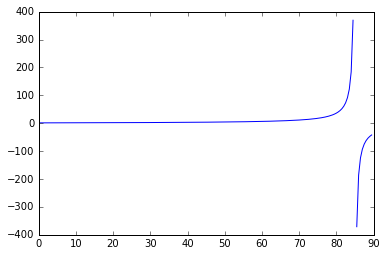

In [130]:
#distance scaling function, engineered to increase slowly up to 70 and rapidly thereafter
x_plot = np.arange(0,90,0.5)
y_plot = (100 + x_plot) / (85 - x_plot) 
plt.plot(x_plot, y_plot)
plt.show

In [132]:
scaled_distances = (100 + distances) / (85 - distances)
scaled_distances[scaled_distances <= 0] = 400 #sets negative values (i.e., angles above 85) to an arbitrarily large distance

array([[   1.17647062,  400.        ,  398.02583958, ...,  355.26924076,
         105.74430349,  400.        ],
       [ 400.        ,    1.17647059,  400.        , ...,  400.        ,
         400.        ,  400.        ],
       [ 398.02583958,  400.        ,    1.17647063, ...,  400.        ,
         400.        ,  400.        ],
       ..., 
       [ 355.26924076,  400.        ,  400.        , ...,    1.17647059,
         400.        ,  400.        ],
       [ 105.74430349,  400.        ,  400.        , ...,  400.        ,
           1.17647059,  400.        ],
       [ 400.        ,  400.        ,  400.        , ...,  400.        ,
         400.        ,    1.17647059]])

In [133]:
from sklearn.cluster import DBSCAN

topic_DBSCAN = DBSCAN(eps=12, min_samples=10, metric='precomputed')
topic_labels = topic_DBSCAN.fit_predict(scaled_distances)

In [146]:
def CharacterizeClassPop(topic_labels):
    '''Given an array of class labels (the output from DBSCAN.fit_predict()), determine how many
    non-noise clusters (i.e., some number besides -1) were assigned, what fraction of articles were assigned to a
    non-noise cluster, and the average, median, and max size of the population of clusters. Returns a dict.'''
    classCounts = np.array(np.unique(topic_labels, return_counts=True)).T #each row contains the class label and the number of occurrences
    assignedClasses = classCounts[1:]
    numClust = assignedClasses.shape[0]
    fracInClust = np.sum(assignedClasses[:,1]) / np.sum(classCounts[:,1])
    avgClustSize = np.sum(assignedClasses[:,1]) / numClust
    medianClustSize = np.median(assignedClasses[:,1])
    maxClustSize = np.max(assignedClasses[:,1])
    
    return {'numClusters':numClust,
           'coverage':fracInClust,
           'avgClusterSize':avgClustSize,
           'medianClusterSize':medianClustSize,
           'maxClusterSize':maxClustSize}

In [243]:
def InfoAboutEachClass(topic_labels):
    '''Given an array of class labels (the output from DBSCAN.fit_predict()), select <= 10 representative
    articles from each class, and the 10 most frequently present words from that cluster. Returns a nested dict.'''
    id_topic = pd.DataFrame(topic_labels, index=epa_entries_with_words, columns=['DB_class'])
    vec_words_by_class = pd.merge(epa_vec_count, id_topic,
                                 how='inner', left_index=True, right_index=True)
    
    id_topic.index = id_topic.index.map(int)
    titles_by_class = pd.merge(epa_titles, id_topic, 
                               how='inner', left_index=True, right_index=True)
    
    classInfo = dict()
    for k in np.unique(topic_labels)[1:].tolist():
        classInfo[k] = dict()
        k_words = vec_words_by_class[vec_words_by_class['DB_class'] == k]
        classMem = k_words.shape[0]
        classInfo[k]['class_members'] = classMem
        present = k_words > np.zeros(k_words.shape)
        present_by_word = np.sum(present, axis=0)
        present_by_word_frac = present_by_word / k_words.shape[0]
        classInfo[k]['top_words'] = present_by_word_frac.sort_values(ascending=False)[:10].to_dict()
        
        sampSize = min(classMem, 10)
        k_titles = titles_by_class[titles_by_class['DB_class'] == k].sample(n=sampSize)
        classInfo[k]['rep_titles'] = k_titles['page_title'].tolist()
    return classInfo

In [223]:
def PrintInfoAboutEachClass(topic_labels):
    '''Given an array of class labels (the output from DBSCAN.fit_predict()), run InfoAboutEachClass() and format
    its output for printing. Returns a formatted string.'''
    
    printInfo = InfoAboutEachClass(topic_labels)
    report = ""
    for key in sorted(printInfo):
        report += "========================\n"
        report += "CLUSTER {}: {} MEMBERS\n\n".format(key, printInfo[key]['class_members'])
        
        report += "Representative articles:\n"
        for article in printInfo[key]['rep_titles']:
            report += article
            report += "\n"
        report += "\nMost common terms:\n"
        for word in sorted(printInfo[key]['top_words'], key=printInfo[key]['top_words'].get, reverse=True):
            report += "{}: {:.3f}\n".format(word, printInfo[key]['top_words'][word])
        report += "========================\n"
    return report

CLUSTER 0: 5275 MEMBERS

Representative articles:
Victoria_Justice
Michael_Oher
Suicide_Squad_(film)
Albert_Pyun
Machete_(film)
Landon_Hedges
List_of_Hail_Mary_passes_in_American_football
Puerto_Ricans
Mahatma_Gandhi
List_of_Teletubbies_episodes_and_videos

Most common terms:
also: 0.383
first: 0.317
american: 0.316
one: 0.302
born: 0.300
includ: 0.296
state: 0.272
known: 0.269
year: 0.241
unit: 0.240
CLUSTER 1: 14 MEMBERS

Representative articles:
Water
Evaporation
Cactus
Rain
Renewable_energy
Water_fluoridation
Ocean
Coral_reef
Water_fluoridation_controversy
Photosynthesis

Most common terms:
DB_class: 1.000
water: 0.929
use: 0.786
also: 0.714
form: 0.643
earth: 0.571
organ: 0.500
exist: 0.500
mani: 0.500
global: 0.500
CLUSTER 2: 13 MEMBERS

Representative articles:
Earth
Google_Earth
Moon
Jupiter
Uranus
Solar_eclipse
Mercury_(element)
Sky
Mercury_(planet)
Venus

Most common terms:
DB_class: 1.000
earth: 0.923
sun: 0.769
moon: 0.769
solar: 0.769
planet: 0.769
system: 0.692
orbit: 0.6

In [248]:
def RunAndAnalyzeDBSCAN(eps, min_samples, scaled_distances):
    '''Given a value for epsilon, the minimum number of samples required for a core point, and a matrix of
    precomputed distances, create a DBSCAN classifier, use it to fit and predict based on the supplied distances, 
    and analyze the output using CharacterizeClassPop and PrintInfoAboutEachClass. Returns a csv formatted string
    containing epsilon, min_samples, numClusters, coverage, avgClusterSize, medianClusterSize, and maxClusterSize'''
    from sklearn.cluster import DBSCAN
    clust = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    topic_labels = clust.fit_predict(scaled_distances)
    numClusters = np.unique(topic_labels).shape[0]
    if numClusters > 1:
        cp = CharacterizeClassPop(topic_labels)
        report = PrintInfoAboutEachClass(topic_labels)
    
        reportFN = "candidate_clusters/{}_{}_clustReport.txt".format(eps, min_samples)
        with open(reportFN, "w") as f:
            f.write(report)
    
        return "{},{},{},{:.3f},{:.0f},{:.0f},{}".format(eps,min_samples,cp['numClusters'],cp['coverage'],cp['avgClusterSize'],
                                        cp['medianClusterSize'],cp['maxClusterSize'])
    else:
        return "{},{},0,0,0,0,0".format(eps,min_samples)

In [249]:
candidate_eps = range(2,13)
candidate_samples = [2,5,10,20,50,100]
with open("DBSCAN_metrics.txt","w") as d:
    d.write("epsilon,min_samples,num_clusters,coverage,avg_cluster_size,median_cluster_size,max_cluster_size\n")
    for eps in candidate_eps:
        for samples in candidate_samples:
            output = RunAndAnalyzeDBSCAN(eps, samples, scaled_distances)
            d.write(output)
            d.write("\n")


,page_title,0
2872345,Lupe_Fiasco,0
598524,Ariel_(city),0
35901300,Bal_des_débutantes,-1
6110688,Splitting_of_the_moon,0
22705211,Southsound_Radio,0
4996831,Dean_Winchester,0
15296435,Faget,0
8933089,List_of_Sindhi-language_poets,0
23324667,Victor_Ponta,0
18940588,A.C._Milan,0
